In [53]:
# !pip install category_encoders

In [117]:
import holidays
import numpy as np
import pandas as pd
import datetime as dt
import category_encoders as ce
import matplotlib.pyplot as plt

from sklearn.model_selection import \
        train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
url = 'https://github.com/mpette200/san_fran_waste/raw/master/data/san_fran_waste_large.zip'
filename = '../data/san_fran_waste_large.zip'
# df = pd.read_csv(filename)
df = pd.read_csv(url)
df

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Point,Source,Media URL
0,12701651,07/28/2020 08:08:03 AM,07/28/2020 09:28:00 AM,07/28/2020 09:28:00 AM,Closed,Case Resolved,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,"3215 17TH ST, SAN FRANCISCO, CA, 94110",17TH ST,9.0,Mission,MISSION,37.763520,-122.417547,"(37.76352028, -122.41754662)",Mobile/Open311,http://mobile311.sfgov.org/reports/12701651/ph...
1,12704827,07/28/2020 04:50:02 PM,07/28/2020 05:01:49 PM,07/28/2020 05:01:49 PM,Closed,Case Resolved - WASTE NOT FOUND,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Furniture,"801 TREAT AVE, SAN FRANCISCO, CA, 94110",TREAT AVE,9.0,Mission,MISSION,37.757242,-122.413395,"(37.75724241, -122.41339452)",Mobile/Open311,http://mobile311.sfgov.org/reports/12704827/ph...
2,12705439,07/28/2020 07:13:00 PM,07/28/2020 08:05:00 PM,07/28/2020 08:05:00 PM,Closed,Case Resolved,DPW Ops Queue,Street and Sidewalk Cleaning,Medical Waste,Needles,Intersection of HICKORY ST and GOUGH ST,HICKORY ST,5.0,Hayes Valley,NORTHERN,37.775486,-122.422691,"(37.77548599, -122.42269135)",Phone,NaN
3,12705346,07/28/2020 06:41:07 PM,NaN,07/28/2020 06:43:24 PM,Open,accepted,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Furniture,"623 17TH AVE, SAN FRANCISCO, CA, 94121",17TH AVE,1.0,Inner Richmond,RICHMOND,37.776128,-122.476179,"(37.77612768, -122.47617904)",Mobile/Open311,NaN
4,12705917,07/28/2020 11:53:12 PM,NaN,07/29/2020 04:06:32 AM,Open,accepted,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Mattress,"1366 VERMONT ST, SAN FRANCISCO, CA, 94110",VERMONT ST,10.0,Potrero Hill,MISSION,37.752282,-122.403479,"(37.75228233, -122.40347944)",Mobile/Open311,http://mobile311.sfgov.org/reports/12705917/ph...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990195,4890831,07/08/2015 08:47:31 AM,07/08/2015 10:00:00 AM,07/08/2015 10:00:00 AM,Closed,Case Completed - resolved:,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,Intersection of SAN JOSE AVE and LAKEVIEW AVE,SAN JOSE AVE,11.0,Oceanview,TARAVAL,37.716167,-122.450378,"(37.71616745, -122.45037842)",Phone,NaN
990196,4890840,07/08/2015 08:48:41 AM,07/08/2015 06:15:27 PM,07/08/2015 06:15:27 PM,Closed,Case Completed - resolved: Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Mattress,"3099 22ND ST, SAN FRANCISCO, CA, 94110",22ND ST,9.0,Mission,MISSION,37.755292,-122.416512,"(37.75529167, -122.41651167)",Mobile/Open311,http://mobile311.sfgov.org/reports/4890840/photos
990197,4890846,07/08/2015 08:49:56 AM,07/08/2015 09:25:47 AM,07/08/2015 09:25:47 AM,Closed,Case Completed - resolved: Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Furniture,Intersection of 22ND ST and FLORIDA ST,22ND ST,9.0,Mission,MISSION,37.756007,-122.410348,"(37.75600749, -122.41034799)",Mobile/Open311,http://mobile311.sfgov.org/reports/4890846/photos
990198,4890847,07/08/2015 08:50:13 AM,07/08/2015 10:23:12 AM,07/08/2015 10:23:12 AM,Closed,Case Completed - resolved: WASTE NOT FOUND,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Furniture,"3101 21ST ST, SAN FRANCISCO, CA, 94110",21ST ST,9.0,Mission,MISSION,37.757008,-122.416790,"(37.75700766, -122.41678957)",Mobile/Open311,http://mobile311.sfgov.org/reports/4890847/photos


In [3]:
%%time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990200 entries, 0 to 990199
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CaseID               990200 non-null  int64  
 1   Opened               990200 non-null  object 
 2   Closed               987543 non-null  object 
 3   Updated              990200 non-null  object 
 4   Status               990200 non-null  object 
 5   Status Notes         990174 non-null  object 
 6   Responsible Agency   990200 non-null  object 
 7   Category             990200 non-null  object 
 8   Request Type         990200 non-null  object 
 9   Request Details      990195 non-null  object 
 10  Address              990196 non-null  object 
 11  Street               988022 non-null  object 
 12  Supervisor District  988026 non-null  float64
 13  Neighborhood         987215 non-null  object 
 14  Police District      987020 non-null  object 
 15  Latitude         

In [4]:
dateformat = '%m/%d/%Y %I:%M:%S %p'
test_date = dt.datetime(2006, 7, 24, 16, 50, 2)
print(test_date.strftime(dateformat))

07/24/2006 04:50:02 PM


In [5]:
%%time
df2 = df.copy()
date_columns = ['Opened', 'Closed', 'Updated']
for col in date_columns:
    df2[col] = pd.to_datetime(df2[col], format=dateformat)
df2

CPU times: user 11.4 s, sys: 109 ms, total: 11.5 s
Wall time: 11.5 s


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990200 entries, 0 to 990199
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CaseID               990200 non-null  int64         
 1   Opened               990200 non-null  datetime64[ns]
 2   Closed               987543 non-null  datetime64[ns]
 3   Updated              990200 non-null  datetime64[ns]
 4   Status               990200 non-null  object        
 5   Status Notes         990174 non-null  object        
 6   Responsible Agency   990200 non-null  object        
 7   Category             990200 non-null  object        
 8   Request Type         990200 non-null  object        
 9   Request Details      990195 non-null  object        
 10  Address              990196 non-null  object        
 11  Street               988022 non-null  object        
 12  Supervisor District  988026 non-null  float64       
 13  Neighborhood  

In [7]:
df3 = df2.copy()
df3['Day Opened'] = df3['Opened'].dt.floor('D')
df3['Day Opened'].value_counts()

2020-01-06    1213
2020-01-02    1117
2019-09-03    1093
2018-10-01    1068
2020-06-29    1047
              ... 
2015-02-19       1
2014-02-25       1
2015-05-01       1
2012-01-24       1
2014-03-03       1
Name: Day Opened, Length: 2507, dtype: int64

In [8]:
limit = np.datetime64('2017-01-01')
df3['Day Opened'][df3['Opened'] > limit].value_counts()

2020-01-06    1213
2020-01-02    1117
2019-09-03    1093
2018-10-01    1068
2020-06-29    1047
              ... 
2018-12-25     259
2017-12-25     251
2017-01-22     235
2017-04-16     231
2018-05-19     180
Name: Day Opened, Length: 1305, dtype: int64

In [9]:
to_drop = [
    'CaseID', 'Status', 'Category',
    'Address', 'Point', 'Media URL',
]
df4 = df2.copy()
df4.drop(columns=to_drop, inplace=True)
df4.dropna(inplace=True)
df4['Mins_to_resolve'] = \
    (df4['Closed'] - df4['Opened']).dt.total_seconds() / 60
df4.drop(columns='Closed', inplace=True)
df4

,Opened,Updated,Status Notes,Responsible Agency,Request Type,Request Details,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source,Mins_to_resolve
0,2020-07-28 08:08:03,2020-07-28 09:28:00,Case Resolved,DPW Ops Queue,General Cleaning,Other Loose Garbage,17TH ST,9.0,Mission,MISSION,37.763520,-122.417547,Mobile/Open311,79.950000
1,2020-07-28 16:50:02,2020-07-28 17:01:49,Case Resolved - WASTE NOT FOUND,Recology_Abandoned,Bulky Items,Furniture,TREAT AVE,9.0,Mission,MISSION,37.757242,-122.413395,Mobile/Open311,11.783333
2,2020-07-28 19:13:00,2020-07-28 20:05:00,Case Resolved,DPW Ops Queue,Medical Waste,Needles,HICKORY ST,5.0,Hayes Valley,NORTHERN,37.775486,-122.422691,Phone,52.000000
6,2020-07-28 12:36:00,2020-07-28 15:52:09,Case Resolved - Pickup completed.,Recology_Abandoned,Bulky Items,Furniture,7TH ST,10.0,Showplace Square,SOUTHERN,37.770687,-122.400558,Phone,196.150000
7,2020-07-28 12:44:00,2020-07-28 13:00:00,Case Transferred,DPW Ops Queue,Human or Animal Waste,Human or Animal Waste,PROSPER ST,8.0,Castro,MISSION,37.762703,-122.431541,Phone,16.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990195,2015-07-08 08:47:31,2015-07-08 10:00:00,Case Completed - resolved:,DPW Ops Queue,General Cleaning,Other Loose Garbage,SAN JOSE AVE,11.0,Oceanview,TARAVAL,37.716167,-122.450378,Phone,72.483333
990196,2015-07-08 08:48:41,2015-07-08 18:15:27,Case Completed - resolved: Pickup completed.,Recology_Abandoned,Bulky Items,Mattress,22ND ST,9.0,Mission,MISSION,37.755292,-122.416512,Mobile/Open311,566.766667
990197,2015-07-08 08:49:56,2015-07-08 09:25:47,Case Completed - resolved: Pickup completed.,Recology_Abandoned,Bulky Items,Furniture,22ND ST,9.0,Mission,MISSION,37.756007,-122.410348,Mobile/Open311,35.850000
990198,2015-07-08 08:50:13,2015-07-08 10:23:12,Case Completed - resolved: WASTE NOT FOUND,Recology_Abandoned,Bulky Items,Furniture,21ST ST,9.0,Mission,MISSION,37.757008,-122.416790,Mobile/Open311,92.983333


In [10]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984360 entries, 0 to 990199
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Opened               984360 non-null  datetime64[ns]
 1   Updated              984360 non-null  datetime64[ns]
 2   Status Notes         984360 non-null  object        
 3   Responsible Agency   984360 non-null  object        
 4   Request Type         984360 non-null  object        
 5   Request Details      984360 non-null  object        
 6   Street               984360 non-null  object        
 7   Supervisor District  984360 non-null  float64       
 8   Neighborhood         984360 non-null  object        
 9   Police District      984360 non-null  object        
 10  Latitude             984360 non-null  float64       
 11  Longitude            984360 non-null  float64       
 12  Source               984360 non-null  object        
 13  Mins_to_resolv

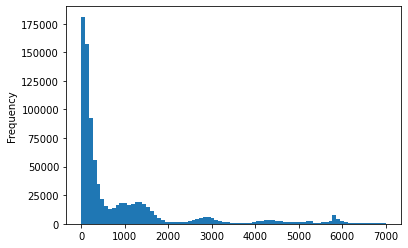

In [85]:
y_tmp = df4['Mins_to_resolve']
outlier_limit = 7000
outliers = (y_tmp < 0) | (y_tmp > outlier_limit)
df5 = df4[~outliers].copy()
df5['Mins_to_resolve'].plot.hist(bins=80)

In [40]:
hols = holidays.US(state='CA', years=range(2015, 2021))
df_h = pd.to_datetime(list(hols))
day = pd.to_timedelta(1, unit='D')
soon_after_holiday = df_h + 1*day
for n in range(2, 4):
  soon_after_holiday = soon_after_holiday.union(df_h + n*day)
soon_after_holiday

DatetimeIndex(['2015-01-02', '2015-01-03', '2015-01-04', '2015-01-20',
               '2015-01-21', '2015-01-22', '2015-02-16', '2015-02-17',
               '2015-02-18', '2015-02-19',
               ...
               '2020-10-15', '2020-11-12', '2020-11-13', '2020-11-14',
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-12-26',
               '2020-12-27', '2020-12-28'],
              dtype='datetime64[ns]', length=217, freq=None)

In [86]:
col_dates = ['Opened', 'Updated']
X = df5.drop(columns='Mins_to_resolve')
y = df5['Mins_to_resolve']
for c in col_dates:
    X['{}_month'.format(c)] = X[c].dt.month
    X['{}_dayofweek'.format(c)] = X[c].dt.dayofweek
    X['{}_hour'.format(c)] = X[c].dt.hour
    X['{}_holiday'.format(c)] = X[c].isin(hols).astype('int')
    X['{}_soon_after_holiday'.format(c)] = \
          X[c].isin(soon_after_holiday).astype('int')
X['Updated_soon_after_holiday'].value_counts()

0    887998
1       564
Name: Updated_soon_after_holiday, dtype: int64

In [87]:
X

,Opened,Updated,Status Notes,Responsible Agency,Request Type,Request Details,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source,Opened_month,Opened_dayofweek,Opened_hour,Opened_holiday,Opened_soon_after_holiday,Updated_month,Updated_dayofweek,Updated_hour,Updated_holiday,Updated_soon_after_holiday
0,2020-07-28 08:08:03,2020-07-28 09:28:00,Case Resolved,DPW Ops Queue,General Cleaning,Other Loose Garbage,17TH ST,9.0,Mission,MISSION,37.763520,-122.417547,Mobile/Open311,7,1,8,0,0,7,1,9,0,0
1,2020-07-28 16:50:02,2020-07-28 17:01:49,Case Resolved - WASTE NOT FOUND,Recology_Abandoned,Bulky Items,Furniture,TREAT AVE,9.0,Mission,MISSION,37.757242,-122.413395,Mobile/Open311,7,1,16,0,0,7,1,17,0,0
2,2020-07-28 19:13:00,2020-07-28 20:05:00,Case Resolved,DPW Ops Queue,Medical Waste,Needles,HICKORY ST,5.0,Hayes Valley,NORTHERN,37.775486,-122.422691,Phone,7,1,19,0,0,7,1,20,0,0
6,2020-07-28 12:36:00,2020-07-28 15:52:09,Case Resolved - Pickup completed.,Recology_Abandoned,Bulky Items,Furniture,7TH ST,10.0,Showplace Square,SOUTHERN,37.770687,-122.400558,Phone,7,1,12,0,0,7,1,15,0,0
7,2020-07-28 12:44:00,2020-07-28 13:00:00,Case Transferred,DPW Ops Queue,Human or Animal Waste,Human or Animal Waste,PROSPER ST,8.0,Castro,MISSION,37.762703,-122.431541,Phone,7,1,12,0,0,7,1,13,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990195,2015-07-08 08:47:31,2015-07-08 10:00:00,Case Completed - resolved:,DPW Ops Queue,General Cleaning,Other Loose Garbage,SAN JOSE AVE,11.0,Oceanview,TARAVAL,37.716167,-122.450378,Phone,7,2,8,0,0,7,2,10,0,0
990196,2015-07-08 08:48:41,2015-07-08 18:15:27,Case Completed - resolved: Pickup completed.,Recology_Abandoned,Bulky Items,Mattress,22ND ST,9.0,Mission,MISSION,37.755292,-122.416512,Mobile/Open311,7,2,8,0,0,7,2,18,0,0
990197,2015-07-08 08:49:56,2015-07-08 09:25:47,Case Completed - resolved: Pickup completed.,Recology_Abandoned,Bulky Items,Furniture,22ND ST,9.0,Mission,MISSION,37.756007,-122.410348,Mobile/Open311,7,2,8,0,0,7,2,9,0,0
990198,2015-07-08 08:50:13,2015-07-08 10:23:12,Case Completed - resolved: WASTE NOT FOUND,Recology_Abandoned,Bulky Items,Furniture,21ST ST,9.0,Mission,MISSION,37.757008,-122.416790,Mobile/Open311,7,2,8,0,0,7,2,10,0,0


In [88]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888562 entries, 0 to 990199
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Opened                      888562 non-null  datetime64[ns]
 1   Updated                     888562 non-null  datetime64[ns]
 2   Status Notes                888562 non-null  object        
 3   Responsible Agency          888562 non-null  object        
 4   Request Type                888562 non-null  object        
 5   Request Details             888562 non-null  object        
 6   Street                      888562 non-null  object        
 7   Supervisor District         888562 non-null  float64       
 8   Neighborhood                888562 non-null  object        
 9   Police District             888562 non-null  object        
 10  Latitude                    888562 non-null  float64       
 11  Longitude                   888562 non-

In [89]:
y

0          79.950000
1          11.783333
2          52.000000
6         196.150000
7          16.000000
             ...    
990195     72.483333
990196    566.766667
990197     35.850000
990198     92.983333
990199     18.733333
Name: Mins_to_resolve, Length: 888562, dtype: float64

In [105]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=242)

In [121]:
col_categorical = [
    'Status Notes', 'Responsible Agency', 'Request Type',
    'Request Details', 'Street', 'Neighborhood',
    'Police District', 'Source',
]
col_numerical = [
      'Supervisor District', 'Latitude', 'Longitude', 'Opened_month',
      'Opened_dayofweek', 'Opened_hour', 'Opened_holiday',
      'Opened_soon_after_holiday', 'Updated_month', 'Updated_dayofweek',
      'Updated_hour', 'Updated_holiday', 'Updated_soon_after_holiday',
]

preprocess = Pipeline([
    ('cats', ColumnTransformer([
        ('encode', ce.TargetEncoder(), col_categorical),
        ('numbs', MinMaxScaler((0, 1000)), col_numerical)
        ])
    )
])

model = Pipeline([
    ('preprocess', preprocess),
    ('clf', DecisionTreeRegressor(max_depth=15))
])

In [122]:
%%time
model.fit(X_train, y_train)

CPU times: user 13.9 s, sys: 40.5 ms, total: 14 s
Wall time: 14 s


Pipeline(memory=None,
         steps=[('preprocess',
                 Pipeline(memory=None,
                          steps=[('cats',
                                  ColumnTransformer(n_jobs=None,
                                                    remainder='drop',
                                                    sparse_threshold=0.3,
                                                    transformer_weights=None,
                                                    transformers=[('encode',
                                                                   TargetEncoder(cols=None,
                                                                                 drop_invariant=False,
                                                                                 handle_missing='value',
                                                                                 handle_unknown='value',
                                                                                 min_samples_leaf

In [124]:
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

384.79857367299473